In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import edward as ed
import numpy as np
import tensorflow as tf
from edward.models import Beta,Bernoulli,RelaxedBernoulli, MultivariateNormalDiag, Dirichlet, OneHotCategorical,Normal,MultivariateNormalFullCovariance,Mixture,ParamMixture
from edward.models.random_variables import TransformedDistribution
from scipy.stats import norm,lognorm
import math
import time
from build_dataset import build_dataset_1dim_gmm

In [2]:
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }

In [3]:
def hist_point(N,x_data):
    hist = [[] for i in range(80)]
    point = np.array([[0.0]*N]*2,dtype=np.float32)
    width = 0.25
    height = 1.0/(width*N)
    for n in range(N):
        d=x_data[n]
        h=int((d-5.0)/width)
        hist[h].append(n)
        point[0][n]=5.0+h*width
        point[1][n]=(len(hist[h])-1)*height
    return point,width,height

In [50]:
def gmm_bbvi_1dim_gmm_z_mu(N,x_data,n_iter,lambda_m0_init=10.0,lambda_m1_init=20.0):
    start = time.time()
    ds = tf.contrib.distributions
    #generative model 
    pi = 0.5
    mu0 = Normal(loc=tf.constant(10.0),scale=tf.constant(0.5))
    mu1 = Normal(loc=tf.constant(20.0),scale=tf.constant(0.5))
    z = [Bernoulli(probs = pi, dtype = tf.float32) for n in range(N)]
    x = [Normal(loc=mu0*(1.0-z[n])+mu1*z[n],scale=0.5) for n in range(N)]
    print("generative model")
    #variational model
    lambda_m0= tf.Variable(lambda_m0_init)
    lambda_m1= tf.Variable(lambda_m1_init)
    lambda_s0= tf.nn.softplus(tf.Variable(1.5))
    lambda_s1= tf.nn.softplus(tf.Variable(1.5))
    qmu0 = Normal(loc=lambda_m0, scale=lambda_s0) 
    qmu1= Normal(loc=lambda_m1, scale=lambda_s1) 
    #temperature = [tf.Variable(5.0) for n in range(N)]
    temperature = tf.constant(0.66)
    y = [tf.Variable(0.0) for n in range(N)]
    lambda_z = [tf.nn.sigmoid(y[n]) for n in range(N)]
    #qz = [RelaxedBernoulli(temperature[n], probs = lambda_z[n]) for n in range(N)]
    qz=[RelaxedBernoulli(temperature,probs=lambda_z[n]) for n in range(N)]
    print("variational model")
    latent_vars = {z[n]:qz[n] for n in range(N)}
    latent_vars[mu0]=qmu0
    latent_vars[mu1]=qmu1

    data = {x[n]:x_data[n] for n in range(N)}

    inference = ed.KLqp(latent_vars=latent_vars,data=data)
    inference.initialize(n_iter=n_iter,n_samples=1)
    print("inference")
    print(time.time()-start)
    sess=ed.get_session()
    tf.global_variables_initializer().run()
    loss = []
    variational_parameter = []
    variational_parameter.append(sess.run([lambda_m0, lambda_s0, lambda_m1, lambda_s1, lambda_z]))
    for iter in range(inference.n_iter):
            info_dict = inference.update()
            loss.append(info_dict['loss'])
            tmp = sess.run([lambda_m0, lambda_s0, lambda_m1, lambda_s1, lambda_z])
            for idx, lz in enumerate(tmp[4]):
                if lz != lz:
                    print(iter,idx,variational_parameter[iter-1][4][idx])
                    print(time.time()-start)
                    return loss,variational_parameter
                    #lambda_z[idx] = tf.nn.sigmoid(tf.Variable(0.0))
            #variational_parameter.append(tmp)
            
            
    print(time.time()-start)          
    return loss,variational_parameter

<IPython.core.display.Javascript object>


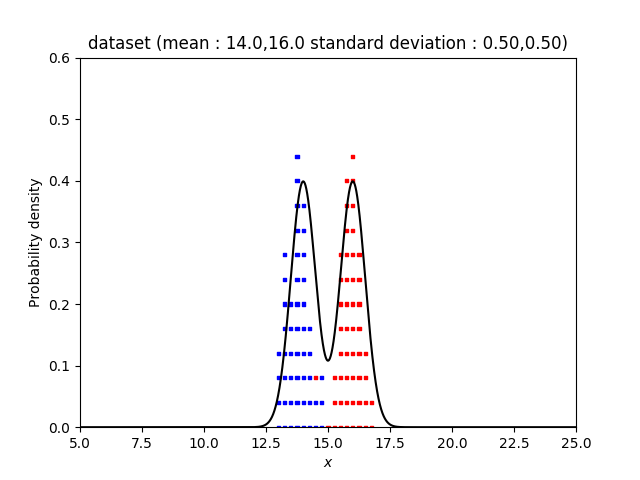

In [45]:
%matplotlib nbagg
N=100
mean_true = np.array([14.0,16.0])
std_true = np.array([0.5,0.5])
pi_true = np.array([0.5,0.5])

x_data,label =build_dataset_1dim_gmm(N,mean_true,std_true,pi_true)
point,width,height = hist_point(N,x_data)

area = [[5.0]*N]
grid = np.linspace(start=5.0,stop=25.0,num=10000)
plt.title("dataset (mean : {0:.1f},".format(mean_true[0]) +"{0:.1f} ".format(mean_true[1])+"standard deviation : {0:.2f},".format(std_true[0])+"{0:.2f})".format(std_true[1]))
plt.xlabel("$x$")
plt.ylabel("Probability density")
plt.xlim(5.0,25.0)
plt.ylim(0.0,0.6)
plt.plot(grid,norm.pdf(x=grid,loc=mean_true[0], scale=std_true[0])*pi_true[0]+norm.pdf(x=grid,loc=mean_true[1], scale=std_true[1])*pi_true[1],color="black")
color =[]
for t,p in enumerate(label):
    color.append([p,0.0,1.0-p])
plt.scatter(point[0],point[1],s=area,c=color,marker='s')
plt.show()
#plt.savefig("dataset_ex3.png")


In [51]:
loss, variational_parameter = gmm_bbvi_1dim_gmm_z_mu(N,x_data,n_iter=500,lambda_m0_init=12.0,lambda_m1_init=18.0 )

generative model
variational model


KeyboardInterrupt: 

<IPython.core.display.Javascript object>


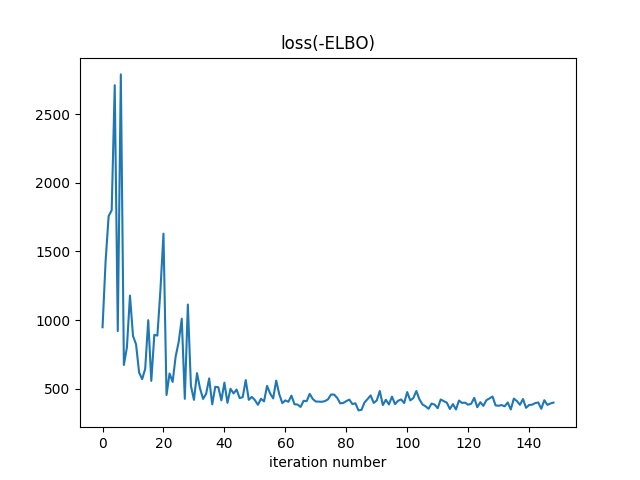

In [28]:
%matplotlib nbagg
plt.title("loss(-ELBO)")
plt.plot(loss)
plt.xlabel("iteration number")
plt.show()
#plt.savefig("loss_ex3.png")

<IPython.core.display.Javascript object>


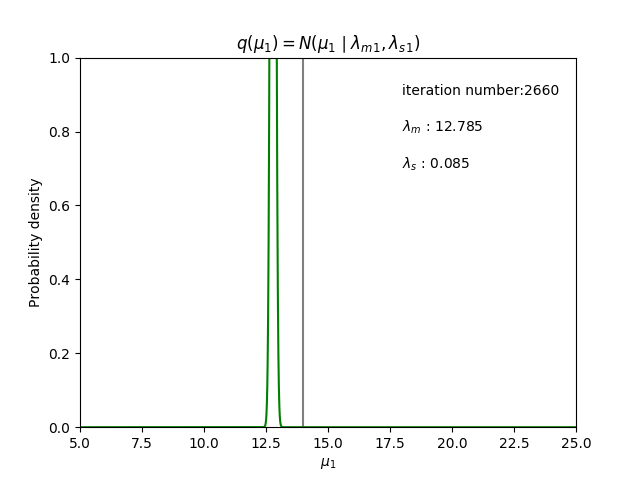

In [29]:
%matplotlib nbagg
grid = np.linspace(start=5.0,stop=25.0,num=10000)
fig = plt.figure()
plt.title("$q(\mu_1)=N(\mu_1\mid{\lambda_m}_1,{\lambda_s}_1)$")
plt.xlabel("$\mu_1$")
plt.ylabel("Probability density")
plt.xlim(5.0,25.0)
plt.ylim(0.0,1.0)
plt.axvline(x=mean_true[0],color="gray")
artists = []
for t,vp in enumerate(variational_parameter):
    if t%10 == 0:
        im = plt.plot(grid,norm.pdf(x=grid,loc=vp[0], scale=vp[1]),color="green")
        text = [plt.text(18,0.9,"iteration number:"+str(t)),
                     plt.text(18,0.8,"$\lambda_m$ : {0:.3f}".format(vp[0])),
                     plt.text(18,0.7,"$\lambda_s$ : {0:.3f}".format(vp[1]))]
        artists.append(im+text)
ani = animation.ArtistAnimation(fig,artists)
plt.show()
#ani.save("mu1_ex3.gif", writer='imagemagick', fps=4)

<IPython.core.display.Javascript object>


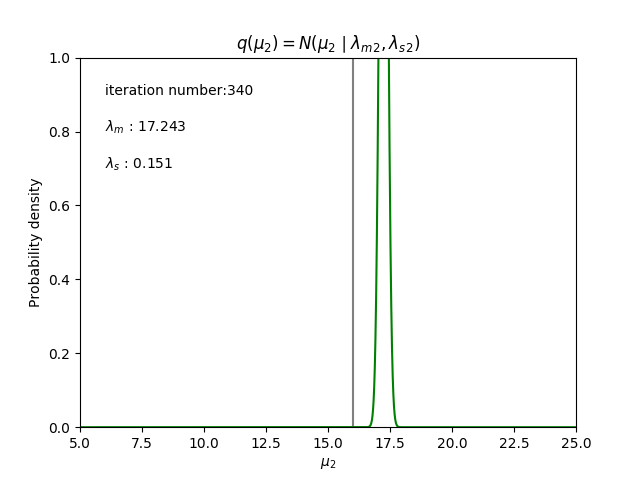

In [30]:
%matplotlib nbagg
grid = np.linspace(start=5.0,stop=25.0,num=10000)
fig = plt.figure()
plt.title("$q(\mu_2)=N(\mu_2\mid{\lambda_m}_2,{\lambda_s}_2)$")
plt.xlabel("$\mu_2$")
plt.ylabel("Probability density")
plt.xlim(5.0,25.0)
plt.ylim(0.0,1.0)
plt.axvline(x=mean_true[1],color="gray")
artists = []
for t,vp in enumerate(variational_parameter):
    if t%10 == 0:
        im = plt.plot(grid,norm.pdf(x=grid,loc=vp[2], scale=vp[3]),color="green")
        text = [plt.text(6,0.9,"iteration number:"+str(t)),
                     plt.text(6,0.8,"$\lambda_m$ : {0:.3f}".format(vp[2])),
                     plt.text(6,0.7,"$\lambda_s$ : {0:.3f}".format(vp[3]))]
        artists.append(im+text)
ani = animation.ArtistAnimation(fig,artists)
plt.show()
#ani.save("mu2_ex3.gif", writer='imagemagick', fps=4)

<IPython.core.display.Javascript object>


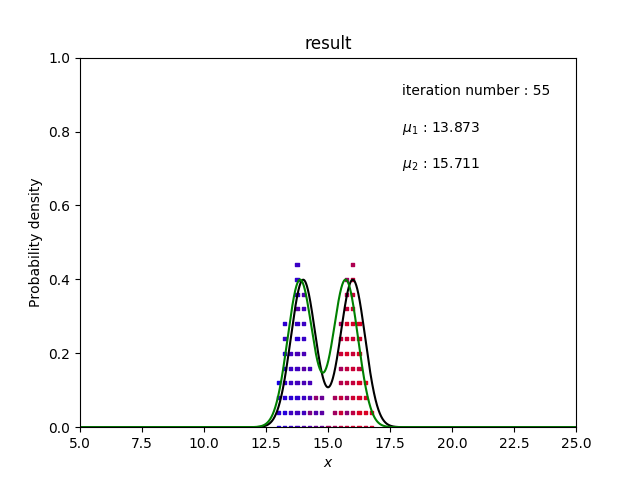

/home/tanaka/.pyenv/versions/anaconda3-4.4.0/envs/tfed/lib/python3.5/site-packages/matplotlib/colors.py:251: RuntimeWarning: invalid value encountered in less
  if np.any((result < 0) | (result > 1)):
/home/tanaka/.pyenv/versions/anaconda3-4.4.0/envs/tfed/lib/python3.5/site-packages/matplotlib/colors.py:251: RuntimeWarning: invalid value encountered in greater
  if np.any((result < 0) | (result > 1)):
/home/tanaka/.pyenv/versions/anaconda3-4.4.0/envs/tfed/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/home/tanaka/.pyenv/versions/anaconda3-4.4.0/envs/tfed/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)


In [35]:
%matplotlib nbagg
grid = np.linspace(start=5.0,stop=25.0,num=10000)
fig = plt.figure()
plt.title("result")
plt.xlabel("$x$")
plt.ylabel("Probability density")
plt.xlim(5.0,25.0)
plt.ylim(0.0,1.0)
plt.plot(grid,norm.pdf(x=grid,loc=mean_true[0], scale=std_true[0])*pi_true[0]+norm.pdf(x=grid,loc=mean_true[1], scale=std_true[1])*pi_true[1],color="black")
area = [[5.0]*N]

artists = []
for t,vp in enumerate(variational_parameter):
    if t%5 == 0:
        im=plt.plot(grid,norm.pdf(x=grid,loc=vp[0], scale=std_true[0])*pi_true[0]+norm.pdf(x=grid,loc=vp[2], scale=std_true[1])*pi_true[1],
                 color="green")
        color =[]
        for zn,p in enumerate(vp[4]):
            color.append([p,0.0,1.0-p])
        im_z=plt.scatter(point[0],point[1],s=area,c=color,marker='s')
        text = [plt.text(18,0.9,"iteration number : "+str(t)),
                     plt.text(18,0.8,"$\mu_1$ : {0:.3f}".format(vp[0])),
                     plt.text(18,0.7,"$\mu_2$ : {0:.3f}".format(vp[2]))]
        artists.append(im+[im_z]+text)
ani = animation.ArtistAnimation(fig,artists)
#plt.show()
ani.save("GMM_2_result.gif", writer='imagemagick', fps=4)

In [49]:
for t,vp in enumerate(variational_parameter):
    if t % 10 == 0:
        for k, l in enumerate(vp[4]):
            print(t,k,l,label[k])

0 0 0.5 0.0
0 1 0.5 0.0
0 2 0.5 0.0
0 3 0.5 0.0
0 4 0.5 0.0
0 5 0.5 0.0
0 6 0.5 0.0
0 7 0.5 0.0
0 8 0.5 0.0
0 9 0.5 0.0
0 10 0.5 0.0
0 11 0.5 0.0
0 12 0.5 0.0
0 13 0.5 0.0
0 14 0.5 0.0
0 15 0.5 0.0
0 16 0.5 0.0
0 17 0.5 0.0
0 18 0.5 0.0
0 19 0.5 0.0
0 20 0.5 0.0
0 21 0.5 0.0
0 22 0.5 0.0
0 23 0.5 0.0
0 24 0.5 0.0
0 25 0.5 0.0
0 26 0.5 0.0
0 27 0.5 0.0
0 28 0.5 0.0
0 29 0.5 0.0
0 30 0.5 0.0
0 31 0.5 0.0
0 32 0.5 0.0
0 33 0.5 0.0
0 34 0.5 0.0
0 35 0.5 0.0
0 36 0.5 0.0
0 37 0.5 0.0
0 38 0.5 0.0
0 39 0.5 0.0
0 40 0.5 0.0
0 41 0.5 0.0
0 42 0.5 0.0
0 43 0.5 0.0
0 44 0.5 0.0
0 45 0.5 0.0
0 46 0.5 0.0
0 47 0.5 0.0
0 48 0.5 0.0
0 49 0.5 0.0
0 50 0.5 1.0
0 51 0.5 1.0
0 52 0.5 1.0
0 53 0.5 1.0
0 54 0.5 1.0
0 55 0.5 1.0
0 56 0.5 1.0
0 57 0.5 1.0
0 58 0.5 1.0
0 59 0.5 1.0
0 60 0.5 1.0
0 61 0.5 1.0
0 62 0.5 1.0
0 63 0.5 1.0
0 64 0.5 1.0
0 65 0.5 1.0
0 66 0.5 1.0
0 67 0.5 1.0
0 68 0.5 1.0
0 69 0.5 1.0
0 70 0.5 1.0
0 71 0.5 1.0
0 72 0.5 1.0
0 73 0.5 1.0
0 74 0.5 1.0
0 75 0.5 1.0
0 76 0.5 1.0
0 77 0.5 

80 26 0.170641 0.0
80 27 0.271869 0.0
80 28 0.169812 0.0
80 29 0.175963 0.0
80 30 0.212748 0.0
80 31 0.445963 0.0
80 32 0.292295 0.0
80 33 0.137574 0.0
80 34 0.314615 0.0
80 35 0.143109 0.0
80 36 0.239976 0.0
80 37 0.14503 0.0
80 38 0.190532 0.0
80 39 0.215917 0.0
80 40 0.287712 0.0
80 41 0.265019 0.0
80 42 0.183508 0.0
80 43 0.188944 0.0
80 44 0.117996 0.0
80 45 0.217231 0.0
80 46 0.224409 0.0
80 47 0.333123 0.0
80 48 0.330837 0.0
80 49 0.0874849 0.0
80 50 0.866414 1.0
80 51 0.805742 1.0
80 52 0.762257 1.0
80 53 0.883053 1.0
80 54 0.833699 1.0
80 55 0.867898 1.0
80 56 0.778213 1.0
80 57 0.649991 1.0
80 58 0.832973 1.0
80 59 0.859133 1.0
80 60 0.707504 1.0
80 61 0.760796 1.0
80 62 0.678199 1.0
80 63 0.664614 1.0
80 64 0.87223 1.0
80 65 0.873136 1.0
80 66 0.794736 1.0
80 67 0.851952 1.0
80 68 0.827095 1.0
80 69 0.761558 1.0
80 70 0.790539 1.0
80 71 0.873446 1.0
80 72 0.854661 1.0
80 73 0.900612 1.0
80 74 0.529834 1.0
80 75 0.823938 1.0
80 76 0.823483 1.0
80 77 0.788549 1.0
80 78 0.80266

160 67 nan 1.0
160 68 nan 1.0
160 69 nan 1.0
160 70 nan 1.0
160 71 nan 1.0
160 72 nan 1.0
160 73 nan 1.0
160 74 nan 1.0
160 75 nan 1.0
160 76 nan 1.0
160 77 nan 1.0
160 78 nan 1.0
160 79 nan 1.0
160 80 nan 1.0
160 81 nan 1.0
160 82 nan 1.0
160 83 nan 1.0
160 84 nan 1.0
160 85 nan 1.0
160 86 nan 1.0
160 87 nan 1.0
160 88 nan 1.0
160 89 nan 1.0
160 90 nan 1.0
160 91 nan 1.0
160 92 nan 1.0
160 93 nan 1.0
160 94 nan 1.0
160 95 nan 1.0
160 96 nan 1.0
160 97 nan 1.0
160 98 nan 1.0
160 99 nan 1.0
170 0 nan 0.0
170 1 nan 0.0
170 2 nan 0.0
170 3 nan 0.0
170 4 nan 0.0
170 5 nan 0.0
170 6 nan 0.0
170 7 nan 0.0
170 8 nan 0.0
170 9 nan 0.0
170 10 nan 0.0
170 11 nan 0.0
170 12 nan 0.0
170 13 nan 0.0
170 14 nan 0.0
170 15 nan 0.0
170 16 nan 0.0
170 17 nan 0.0
170 18 nan 0.0
170 19 nan 0.0
170 20 nan 0.0
170 21 nan 0.0
170 22 nan 0.0
170 23 nan 0.0
170 24 nan 0.0
170 25 nan 0.0
170 26 nan 0.0
170 27 nan 0.0
170 28 nan 0.0
170 29 nan 0.0
170 30 nan 0.0
170 31 nan 0.0
170 32 nan 0.0
170 33 nan 0.0
170 3

250 41 nan 0.0
250 42 nan 0.0
250 43 nan 0.0
250 44 nan 0.0
250 45 nan 0.0
250 46 nan 0.0
250 47 nan 0.0
250 48 nan 0.0
250 49 nan 0.0
250 50 nan 1.0
250 51 nan 1.0
250 52 nan 1.0
250 53 nan 1.0
250 54 nan 1.0
250 55 nan 1.0
250 56 nan 1.0
250 57 nan 1.0
250 58 nan 1.0
250 59 nan 1.0
250 60 nan 1.0
250 61 nan 1.0
250 62 nan 1.0
250 63 nan 1.0
250 64 nan 1.0
250 65 nan 1.0
250 66 nan 1.0
250 67 nan 1.0
250 68 nan 1.0
250 69 nan 1.0
250 70 nan 1.0
250 71 nan 1.0
250 72 nan 1.0
250 73 nan 1.0
250 74 nan 1.0
250 75 nan 1.0
250 76 nan 1.0
250 77 nan 1.0
250 78 nan 1.0
250 79 nan 1.0
250 80 nan 1.0
250 81 nan 1.0
250 82 nan 1.0
250 83 nan 1.0
250 84 nan 1.0
250 85 nan 1.0
250 86 nan 1.0
250 87 nan 1.0
250 88 nan 1.0
250 89 nan 1.0
250 90 nan 1.0
250 91 nan 1.0
250 92 nan 1.0
250 93 nan 1.0
250 94 nan 1.0
250 95 nan 1.0
250 96 nan 1.0
250 97 nan 1.0
250 98 nan 1.0
250 99 nan 1.0
260 0 nan 0.0
260 1 nan 0.0
260 2 nan 0.0
260 3 nan 0.0
260 4 nan 0.0
260 5 nan 0.0
260 6 nan 0.0
260 7 nan 0.0
260

350 41 nan 0.0
350 42 nan 0.0
350 43 nan 0.0
350 44 nan 0.0
350 45 nan 0.0
350 46 nan 0.0
350 47 nan 0.0
350 48 nan 0.0
350 49 nan 0.0
350 50 nan 1.0
350 51 nan 1.0
350 52 nan 1.0
350 53 nan 1.0
350 54 nan 1.0
350 55 nan 1.0
350 56 nan 1.0
350 57 nan 1.0
350 58 nan 1.0
350 59 nan 1.0
350 60 nan 1.0
350 61 nan 1.0
350 62 nan 1.0
350 63 nan 1.0
350 64 nan 1.0
350 65 nan 1.0
350 66 nan 1.0
350 67 nan 1.0
350 68 nan 1.0
350 69 nan 1.0
350 70 nan 1.0
350 71 nan 1.0
350 72 nan 1.0
350 73 nan 1.0
350 74 nan 1.0
350 75 nan 1.0
350 76 nan 1.0
350 77 nan 1.0
350 78 nan 1.0
350 79 nan 1.0
350 80 nan 1.0
350 81 nan 1.0
350 82 nan 1.0
350 83 nan 1.0
350 84 nan 1.0
350 85 nan 1.0
350 86 nan 1.0
350 87 nan 1.0
350 88 nan 1.0
350 89 nan 1.0
350 90 nan 1.0
350 91 nan 1.0
350 92 nan 1.0
350 93 nan 1.0
350 94 nan 1.0
350 95 nan 1.0
350 96 nan 1.0
350 97 nan 1.0
350 98 nan 1.0
350 99 nan 1.0
360 0 nan 0.0
360 1 nan 0.0
360 2 nan 0.0
360 3 nan 0.0
360 4 nan 0.0
360 5 nan 0.0
360 6 nan 0.0
360 7 nan 0.0
360

450 41 nan 0.0
450 42 nan 0.0
450 43 nan 0.0
450 44 nan 0.0
450 45 nan 0.0
450 46 nan 0.0
450 47 nan 0.0
450 48 nan 0.0
450 49 nan 0.0
450 50 nan 1.0
450 51 nan 1.0
450 52 nan 1.0
450 53 nan 1.0
450 54 nan 1.0
450 55 nan 1.0
450 56 nan 1.0
450 57 nan 1.0
450 58 nan 1.0
450 59 nan 1.0
450 60 nan 1.0
450 61 nan 1.0
450 62 nan 1.0
450 63 nan 1.0
450 64 nan 1.0
450 65 nan 1.0
450 66 nan 1.0
450 67 nan 1.0
450 68 nan 1.0
450 69 nan 1.0
450 70 nan 1.0
450 71 nan 1.0
450 72 nan 1.0
450 73 nan 1.0
450 74 nan 1.0
450 75 nan 1.0
450 76 nan 1.0
450 77 nan 1.0
450 78 nan 1.0
450 79 nan 1.0
450 80 nan 1.0
450 81 nan 1.0
450 82 nan 1.0
450 83 nan 1.0
450 84 nan 1.0
450 85 nan 1.0
450 86 nan 1.0
450 87 nan 1.0
450 88 nan 1.0
450 89 nan 1.0
450 90 nan 1.0
450 91 nan 1.0
450 92 nan 1.0
450 93 nan 1.0
450 94 nan 1.0
450 95 nan 1.0
450 96 nan 1.0
450 97 nan 1.0
450 98 nan 1.0
450 99 nan 1.0
460 0 nan 0.0
460 1 nan 0.0
460 2 nan 0.0
460 3 nan 0.0
460 4 nan 0.0
460 5 nan 0.0
460 6 nan 0.0
460 7 nan 0.0
460